In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.metrics import AUC

2024-05-11 20:27:38.311079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 20:27:38.311173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 20:27:38.438712: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
IMG_SIZE = 512
BATCH_SIZE = 16
IMG_SIZEH = 256

In [4]:
import shutil
import os

# Source and destination paths
source_path = "/kaggle/input/all-mias/"
destination_path = "/kaggle/working/all-mias0/"

# Create the destination folder if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Get a list of all files in the source folder
files = os.listdir(source_path)

# Copy each file from the source folder to the destination folder
for file in files:
    source_file_path = os.path.join(source_path, file)
    destination_file_path = os.path.join(destination_path, file)
    shutil.copy2(source_file_path, destination_file_path)


In [5]:
def convert_pgm_to_jpg(input_folder, output_folder):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".pgm"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename.replace(".pgm", ".jpg"))

            # Convert PGM to JPG
            with open(input_path, 'rb') as f:
                # Read the header
                magic_number = f.readline().decode().strip()
                width, height = map(int, f.readline().decode().split())
                max_val = int(f.readline().decode())

                # Check if it's a valid PGM file
                if magic_number != 'P5':
                    print("Error: Not a valid PGM file")
                    continue

                # Read the pixel data
                pixel_data = f.read()

            # Create a grayscale mode image using Pillow
            img = Image.frombytes('L', (width, height), pixel_data)

            # Save the image as a JPEG file
            img.save(output_path, format='JPEG')


In [6]:
source_path = "/kaggle/working/all-mias0"
jpg_path = "/kaggle/working/all-mias"
if not os.path.exists(jpg_path):
    os.makedirs(jpg_path)
convert_pgm_to_jpg(source_path, jpg_path)

In [7]:
print("Number of pgm files: ", len(os.listdir(source_path)))
print("Number of jpg files: ", len(os.listdir(jpg_path)))

Number of pgm files:  325
Number of jpg files:  322


(1024, 1024)


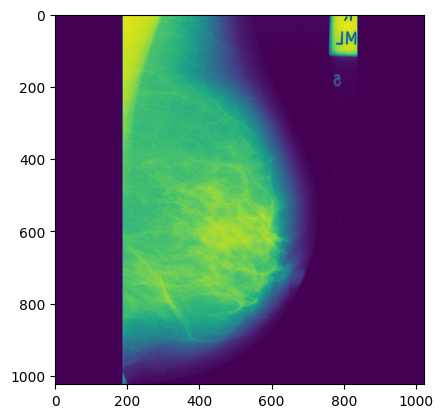

In [8]:
import cv2
img = Image.open("/kaggle/working/all-mias/mdb014.jpg")
print(np.shape(img))
plt.imshow(img)

In [9]:
data = pd.read_csv('/kaggle/input/Info.txt', sep=" ", header=None)
data.columns = ["REFNUM", "BG", "CLASS", "SEVERITY", "X", "Y", "RADIUS", "Naveed" ]

del data['Naveed']

data = data.drop(data.index[0])
data['SEVERITY'] = data['SEVERITY'].fillna('N')
data = data.fillna(0)
data1 = data['BG']

for i in data.index:
    data.loc[i, 'REFNUM'] = '/kaggle/working/all-mias/' + data.loc[i, 'REFNUM'] +'.jpg'
    data.loc[i, 'X'] = int((int(data.loc[i, 'X']))*(IMG_SIZE/1024))
    if data.loc[i, 'Y'] != 0:
        data.loc[i, 'Y'] = int(IMG_SIZE - (int(data.loc[i, 'Y']) *(IMG_SIZE/1024)))
    data.loc[i, 'RADIUS'] = int((int(data.loc[i, 'RADIUS']))*(IMG_SIZE/1024))


In [10]:
data_shape = np.shape(data)
if data_shape[1] > 6:
    del data['BG']
print(data)

                                  REFNUM CLASS SEVERITY    X    Y RADIUS
1    /kaggle/working/all-mias/mdb001.jpg  CIRC        B  267  299     98
2    /kaggle/working/all-mias/mdb002.jpg  CIRC        B  261  372     34
3    /kaggle/working/all-mias/mdb003.jpg  NORM        N    0    0      0
4    /kaggle/working/all-mias/mdb004.jpg  NORM        N    0    0      0
5    /kaggle/working/all-mias/mdb005.jpg  CIRC        B  238  445     15
..                                   ...   ...      ...  ...  ...    ...
326  /kaggle/working/all-mias/mdb318.jpg  NORM        N    0    0      0
327  /kaggle/working/all-mias/mdb319.jpg  NORM        N    0    0      0
328  /kaggle/working/all-mias/mdb320.jpg  NORM        N    0    0      0
329  /kaggle/working/all-mias/mdb321.jpg  NORM        N    0    0      0
330  /kaggle/working/all-mias/mdb322.jpg  NORM        N    0    0      0

[330 rows x 6 columns]


In [11]:

from PIL import ImageDraw

def plot_images_with_circles_and_labels(dataframe, rows=5, cols=3, image_size=IMG_SIZE):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

    for i in range(rows):
        for j in range(cols):
            index = np.random.randint(0, len(dataframe))  # Randomly select an index
            img_path = dataframe.iloc[index, 0]
            img = Image.open(img_path).convert('L')  # Convert image to grayscale
            img = img.resize((image_size, image_size))
            draw = ImageDraw.Draw(img)
            x = int(dataframe.iloc[index, 3])
            y = int(dataframe.iloc[index, 4])
            radius = dataframe.iloc[index, 5]
            draw.ellipse((x-radius, y-radius, x+radius, y+radius), outline="red", width=8)
            axes[i, j].imshow(img)  
            # axes[i,j].imshow(img)
            axes[i, j].axis('off')
            label = dataframe.iloc[index, 2]
            axes[i, j].set_title(f"Severity: {label}", fontsize=12)
    
    plt.tight_layout()
    plt.show()




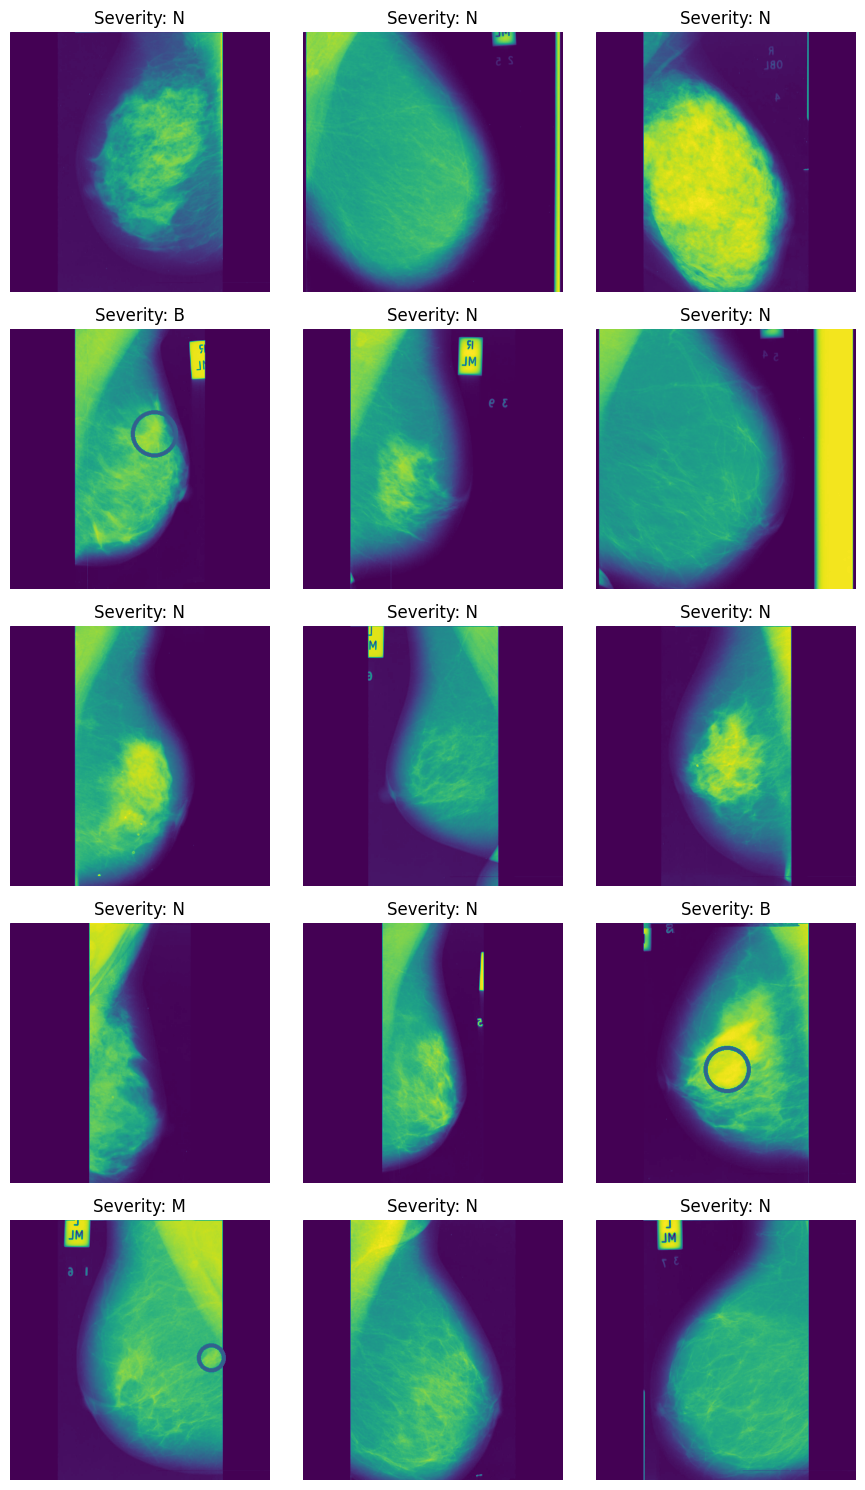

In [12]:
plot_images_with_circles_and_labels(data)


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_with_circles_and_labels(dataframe, rows=5, cols=3, image_size=IMG_SIZE):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

    for i in range(rows):
        for j in range(cols):
            index = np.random.randint(0, len(dataframe))  # Randomly select an index
            img_path = dataframe.iloc[index, 0]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (image_size, image_size))
            x = int(dataframe.iloc[index, 3])
            y = int(dataframe.iloc[index, 4])
            radius = int(dataframe.iloc[index, 5])
            cv2.circle(img, (x, y), radius, (255, 0, 0), 8)  # Draw circle
            axes[i, j].imshow(img, cmap='gray')  # Plot in grayscale
            axes[i, j].axis('off')
            label = dataframe.iloc[index, 2]
            axes[i, j].set_title(f"Severity: {label}", fontsize=12)
    
    plt.tight_layout()
    plt.show()


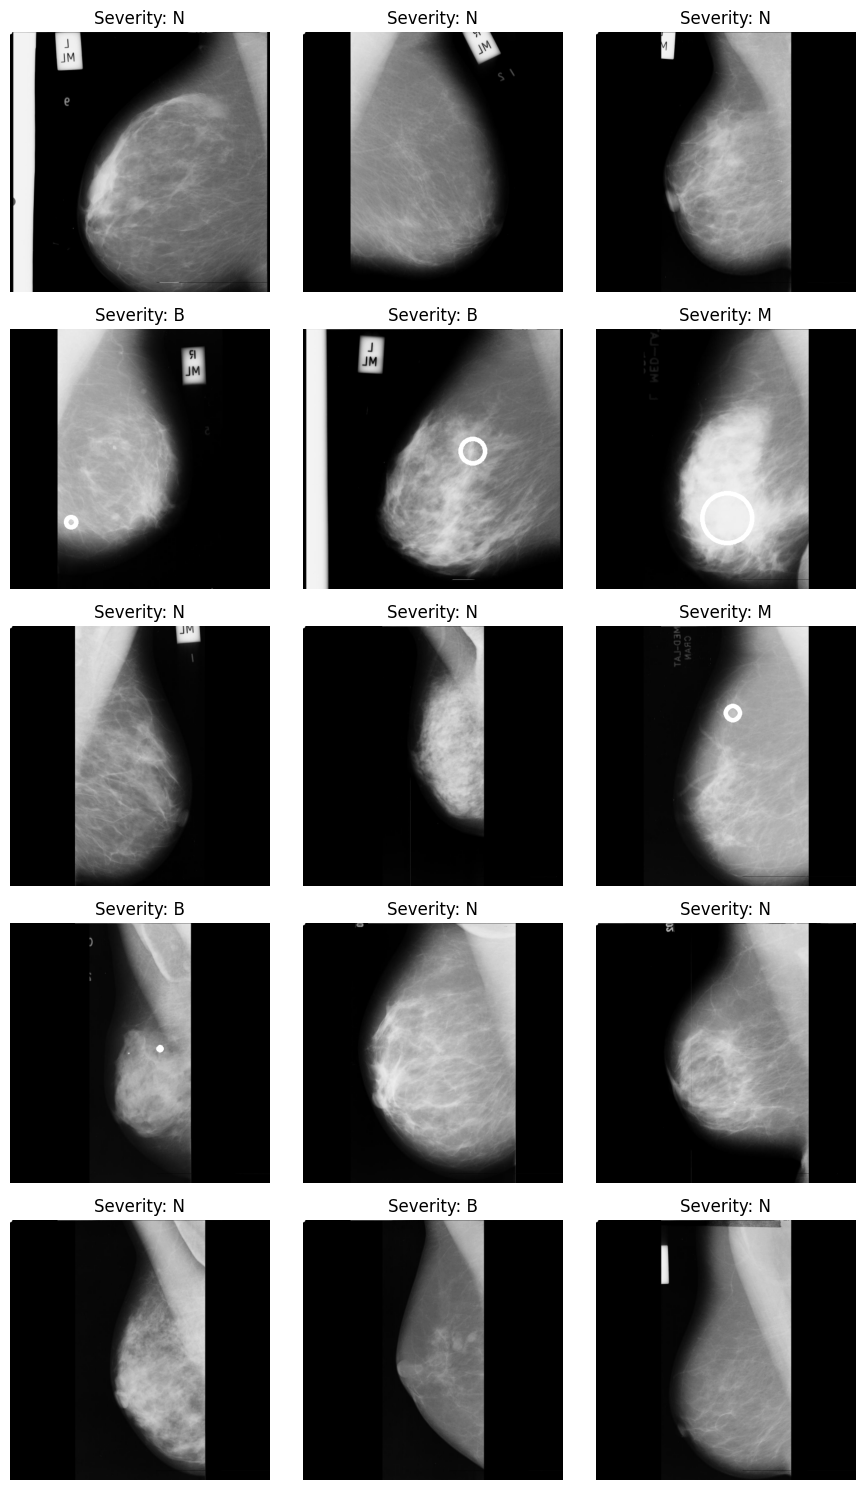

In [14]:
plot_images_with_circles_and_labels(data)


In [15]:
import numpy as np
from scipy.ndimage import zoom

def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [16]:
import math
import sympy as sp
from scipy.optimize import fsolve
from math import sqrt

def solve_equations(a, b, z):
    z1, z2 = 0, 0
    if z < 1:
        z1 = 0.8
        z2 = 0.2
    else:
        z1 = 1.2
        z2 = 0.2

    p = [a, b]
    q = [(IMG_SIZEH), (IMG_SIZEH)]

    # Calculate Euclidean distance
    dis = math.dist(p, q)

    # Define symbolic variables
    x, y = sp.symbols('x y')

    def equations(vars):
      x, y = vars
      eq1 = sqrt(((IMG_SIZEH) - x)**2 + ((IMG_SIZEH) - y)**2) - z1*dis
      eq2 = sqrt((a - x)**2 + (b - y)**2) - z2*dis
      return [eq1, eq2]

    x, y =  fsolve(equations, (1, 1))

    return x, y

In [17]:
import cv2
import numpy as np

def rotate_image(image, angle_degrees):
    # Get the image dimensions
    height, width = image.shape[:2]

    # Calculate the center point
    center = (width // 2, height // 2)

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle_degrees, 1.0)  # 1.0 is the scaling factor (no scaling)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

In [18]:
import math

def rotate_point(x, y, center_x, center_y, angle_degrees):
    angle_radians = math.radians(angle_degrees)  # Convert degrees to radians
    new_x = (x - center_x) * math.cos(angle_radians) - (y - center_y) * math.sin(angle_radians) + center_x
    new_y = (x - center_x) * math.sin(angle_radians) + (y - center_y) * math.cos(angle_radians) + center_y
    return new_x, new_y

In [19]:
import numpy as np
import matplotlib.pyplot as plt
speckl = True

def add_gaussian_noise(image, mean=0, sigma=25):
    if not add_gauss:
        return image
    
    else:
        gaussian_noise = np.random.normal(mean, sigma, image.shape)
        noisy_image = np.clip(image + gaussian_noise, 0, 255).astype(np.uint8)
        return image

def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = np.copy(image)
    salt_pixels = np.random.rand(*image.shape) < salt_prob
    pepper_pixels = np.random.rand(*image.shape) < pepper_prob
    noisy_image[salt_pixels] = 255
    noisy_image[pepper_pixels] = 0
    return image

def add_speckle_noise(image, scale=0.1):
    if not speckl:
        return image
        
    else:
        speckle = np.random.normal(0, scale, image.shape)
        noisy_image = np.clip(image + image * speckle, 0, 255).astype(np.uint8)
        return image

In [20]:
# Add 4 columns with boolean values (all initialized to 0)
data['ZI'] = 0
data['ZO+'] = 0
data['ZO-'] = 0
data['ZO'] = 0
data['vert'] = 0
data['horz'] = 0

# Display the DataFrame after adding new columns
print("\nDataFrame after adding boolean columns:")
print(data)


DataFrame after adding boolean columns:
                                  REFNUM CLASS SEVERITY    X    Y RADIUS  ZI  \
1    /kaggle/working/all-mias/mdb001.jpg  CIRC        B  267  299     98   0   
2    /kaggle/working/all-mias/mdb002.jpg  CIRC        B  261  372     34   0   
3    /kaggle/working/all-mias/mdb003.jpg  NORM        N    0    0      0   0   
4    /kaggle/working/all-mias/mdb004.jpg  NORM        N    0    0      0   0   
5    /kaggle/working/all-mias/mdb005.jpg  CIRC        B  238  445     15   0   
..                                   ...   ...      ...  ...  ...    ...  ..   
326  /kaggle/working/all-mias/mdb318.jpg  NORM        N    0    0      0   0   
327  /kaggle/working/all-mias/mdb319.jpg  NORM        N    0    0      0   0   
328  /kaggle/working/all-mias/mdb320.jpg  NORM        N    0    0      0   0   
329  /kaggle/working/all-mias/mdb321.jpg  NORM        N    0    0      0   0   
330  /kaggle/working/all-mias/mdb322.jpg  NORM        N    0    0      0   0   

In [21]:
DFB = data
DFM = data
DFN = data

condition = (data['SEVERITY'] == "M") | (data['SEVERITY'] == "N")
DFB = data[~condition].reset_index(drop=True)

condition = (data['SEVERITY'] == "B") | (data['SEVERITY'] == "M")
DFN = data[~condition].reset_index(drop=True)

condition = (data['SEVERITY'] == "B") | (data['SEVERITY'] == "N")
DFM = data[~condition].reset_index(drop=True)

print(len(DFM))
print(len(DFN))
print(len(DFB))

54
207
69


In [22]:
from skimage import io
import numpy as np
def random_choice2():
    choices = ['vert', 'horz']
    return np.random.choice(choices)

def flip_aug(df,limit):
    flipped_images=[]
    count = 0

    while count < limit:
        # Randomly pick a row
        index = np.random.choice(df.index)
        row = df.loc[index]

        if row['vert'] and row['horz'] :
            continue
        else :
            count+=1

        choice = random_choice2()
        while row[choice]:
            choice = random_choice2()

        df.loc[index,choice] = 1
        # Load the original image
        original_image = cv2.imread(row['REFNUM'])

        if choice == 'horz':
            flipped_horizontal = add_speckle_noise(cv2.flip(original_image, 1))
            flipped_horizontal_path = row['REFNUM'][:-4] + "_h.jpg"
            io.imsave(flipped_horizontal_path, flipped_horizontal, check_contrast=False)
        
            if row['X']==0:
                new_x = row['X']
            else:
                new_x = IMG_SIZE - row['X']
            

            flipped_images.append({
                'REFNUM': flipped_horizontal_path,
                'X': new_x,
                'Y': row['Y'],
                'SEVERITY': row['SEVERITY'],
                'RADIUS': row['RADIUS'],
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': 1
            })

        else:  # Default to (Vertical)
        
            flipped_v = add_speckle_noise(cv2.flip(original_image, 0))
            flipped_v_path = row['REFNUM'][:-4] + "_v.jpg"
            io.imsave(flipped_v_path, flipped_v, check_contrast=False)
        
            if row['Y']==0:
                new_y = row['Y']
            else:
                new_y = IMG_SIZE - row['Y']
            

            flipped_images.append({
                'REFNUM': flipped_v_path,
                'X': row['X'],
                'Y': new_y,
                'SEVERITY': row['SEVERITY'],
                'RADIUS': row['RADIUS'],
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':1,
                'horz': row['horz']
            })
    
    flipped_df = pd.DataFrame(flipped_images)
    df = pd.concat([df, flipped_df], ignore_index=True)

    return df


In [23]:
import numpy as np
def random_choice():
    choices = ['ZI', 'ZO+', 'ZO-', 'ZO']
    return np.random.choice(choices)

def aug(df,limit):
    flipped_images=[]
    count = 0

    while count < limit:
        # Randomly pick a row
        index = np.random.choice(df.index)
        row = df.loc[index]

        if row['ZI'] and row['ZO+'] and row['ZO-'] and row['ZO'] :
            continue
        else :
            count+=1

        choice = random_choice()
        while row[choice]:
            choice = random_choice()

        df.loc[index,choice] = 1
        # Load the original image
        original_image = cv2.imread(row['REFNUM'])

        if choice == 'ZO+':
            zmo = clipped_zoom(original_image, 0.8)
            ro1 = add_speckle_noise(rotate_image(zmo, 7))
            ro_path = row['REFNUM'][:-4] + "_zo+.jpg"
            io.imsave(ro_path, ro1, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],0.8)
            x1 = int(x1)
            y1 = int(y1)
            x3, y3 = rotate_point(x1, y1, IMG_SIZEH,IMG_SIZEH, -7)
            r1 = int(row['RADIUS']*0.8)

            flipped_images.append({
                'REFNUM': ro_path,
                'X': int(x3),
                'Y': int(y3),
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': row['ZI'],
                'ZO+': 1,
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': row['horz']
              })


        elif choice == 'ZO-':
            zmo = clipped_zoom(original_image, 0.8)
            ro1 = add_speckle_noise(rotate_image(zmo, -7))
            ro_path = row['REFNUM'][:-4] + "_zo-.jpg"
            io.imsave(ro_path, ro1, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],0.8)
            x1 = int(x1)
            y1 = int(y1)
            x3, y3 = rotate_point(x1, y1, IMG_SIZEH,IMG_SIZEH, 7)
            r1 = int(row['RADIUS']*0.8)

            flipped_images.append({
                'REFNUM': ro_path,
                'X': int(x3),
                'Y': int(y3),
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': 1,
                'vert':row['vert'],
                'horz': row['horz']
              })

        elif choice == 'ZO':
            zmo = clipped_zoom(original_image, 0.8)
            zo_path = row['REFNUM'][:-4] + "_zo.jpg"
            io.imsave(zo_path, zmo, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],0.8)
            x1 = int(x1)
            y1 = int(y1)
            r1 = int(row['RADIUS']*0.8)

            flipped_images.append({
                'REFNUM': zo_path,
                'X': x1,
                'Y': y1,
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': 1,
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': row['horz']
              })

        else:  # Default to Zoom In (ZI)
            zmo = clipped_zoom(original_image, 1.2)
            zi_path = row['REFNUM'][:-4] + "_zi.jpg"
            io.imsave(zi_path, zmo, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],1.2)
            x1 = int(x1)
            y1 = int(y1)
            r1 = int(row['RADIUS']*1.2)

            flipped_images.append({
                'REFNUM': zi_path,
                'X': x1,
                'Y': y1,
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': 1,
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': row['horz']
              })
    flipped_df = pd.DataFrame(flipped_images)
    df = pd.concat([df, flipped_df], ignore_index=True)

    return df


In [24]:
DFM = flip_aug(DFM,79)
DFM = aug(DFM,270)
print(DFM)

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minp

                                        REFNUM CLASS SEVERITY    X    Y  \
0          /kaggle/working/all-mias/mdb023.jpg  CIRC        M  269  171   
1          /kaggle/working/all-mias/mdb028.jpg  CIRC        M  169  355   
2          /kaggle/working/all-mias/mdb058.jpg  MISC        M  159  332   
3          /kaggle/working/all-mias/mdb072.jpg  ASYM        M  133  253   
4          /kaggle/working/all-mias/mdb075.jpg  ASYM        M  234  153   
..                                         ...   ...      ...  ...  ...   
398    /kaggle/working/all-mias/mdb171_zo-.jpg   NaN        M  240  206   
399  /kaggle/working/all-mias/mdb171_v_zo+.jpg   NaN        M  240  304   
400  /kaggle/working/all-mias/mdb158_v_zo-.jpg   NaN        M  264  278   
401     /kaggle/working/all-mias/mdb120_zo.jpg   NaN        M  219  355   
402  /kaggle/working/all-mias/mdb264_h_zo+.jpg   NaN        M  226  290   

    RADIUS  ZI  ZO+  ZO-  ZO  vert  horz  
0       14   1    0    0   1     1     1  
1       28   

In [25]:
DFB = flip_aug(DFB,94)
DFB = aug(DFB,260)
print(DFB)

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minp

                                        REFNUM CLASS SEVERITY    X    Y  \
0          /kaggle/working/all-mias/mdb001.jpg  CIRC        B  267  299   
1          /kaggle/working/all-mias/mdb002.jpg  CIRC        B  261  372   
2          /kaggle/working/all-mias/mdb005.jpg  CIRC        B  238  445   
3          /kaggle/working/all-mias/mdb005.jpg  CIRC        B  250  428   
4          /kaggle/working/all-mias/mdb010.jpg  CIRC        B  262  299   
..                                         ...   ...      ...  ...  ...   
418   /kaggle/working/all-mias/mdb030_h_zi.jpg   NaN        B  370  157   
419   /kaggle/working/all-mias/mdb097_v_zi.jpg   NaN        B  315  127   
420   /kaggle/working/all-mias/mdb290_v_zi.jpg   NaN        B  150  161   
421   /kaggle/working/all-mias/mdb132_v_zo.jpg   NaN        B  184  357   
422  /kaggle/working/all-mias/mdb252_v_zo-.jpg   NaN        B  233  194   

    RADIUS  ZI  ZO+  ZO-  ZO  vert  horz  
0       98   1    0    0   0     0     1  
1       34   

In [26]:
DFN = flip_aug(DFN,50)
DFN = aug(DFN,150)
print(DFN)

                                      REFNUM CLASS SEVERITY    X    Y RADIUS  \
0        /kaggle/working/all-mias/mdb003.jpg  NORM        N    0    0      0   
1        /kaggle/working/all-mias/mdb004.jpg  NORM        N    0    0      0   
2        /kaggle/working/all-mias/mdb006.jpg  NORM        N    0    0      0   
3        /kaggle/working/all-mias/mdb007.jpg  NORM        N    0    0      0   
4        /kaggle/working/all-mias/mdb008.jpg  NORM        N    0    0      0   
..                                       ...   ...      ...  ...  ...    ...   
402  /kaggle/working/all-mias/mdb311_zo+.jpg   NaN        N   27   77      0   
403   /kaggle/working/all-mias/mdb026_zo.jpg   NaN        N   51   51      0   
404  /kaggle/working/all-mias/mdb138_zo+.jpg   NaN        N   27   77      0   
405   /kaggle/working/all-mias/mdb138_zi.jpg   NaN        N  -51  -51      0   
406  /kaggle/working/all-mias/mdb299_zo-.jpg   NaN        N   77   27      0   

     ZI  ZO+  ZO-  ZO  vert  horz  
0  

In [27]:
print(len(DFM))
print(len(DFN))
print(len(DFB))

DFN['X'] = 0
DFN['Y'] = 0
print(DFN)

403
407
423
                                      REFNUM CLASS SEVERITY  X  Y RADIUS  ZI  \
0        /kaggle/working/all-mias/mdb003.jpg  NORM        N  0  0      0   0   
1        /kaggle/working/all-mias/mdb004.jpg  NORM        N  0  0      0   0   
2        /kaggle/working/all-mias/mdb006.jpg  NORM        N  0  0      0   1   
3        /kaggle/working/all-mias/mdb007.jpg  NORM        N  0  0      0   0   
4        /kaggle/working/all-mias/mdb008.jpg  NORM        N  0  0      0   0   
..                                       ...   ...      ... .. ..    ...  ..   
402  /kaggle/working/all-mias/mdb311_zo+.jpg   NaN        N  0  0      0   0   
403   /kaggle/working/all-mias/mdb026_zo.jpg   NaN        N  0  0      0   1   
404  /kaggle/working/all-mias/mdb138_zo+.jpg   NaN        N  0  0      0   0   
405   /kaggle/working/all-mias/mdb138_zi.jpg   NaN        N  0  0      0   1   
406  /kaggle/working/all-mias/mdb299_zo-.jpg   NaN        N  0  0      0   1   

     ZO+  ZO-  ZO  vert  ho

In [28]:
import pandas as pd
from sklearn.utils import shuffle

# Assuming DFB, DFM, and DFN are your DataFrames
num = 120
# Shuffle the rows of each DataFrame
DFB_shuffled = shuffle(DFB,random_state=70)
DFM_shuffled = shuffle(DFM,random_state=80)
DFN_shuffled = shuffle(DFN,random_state=90)



In [29]:
# Select the remaining rows (starting from the 42nd row) from each shuffled DataFrame
dftrain = pd.concat([DFB_shuffled.iloc[num:], DFM_shuffled.iloc[num:], DFN_shuffled.iloc[num:]], ignore_index=True)
#dftrain = pd.concat([DFB_shuffled.iloc[num:], DFM_shuffled.iloc[num:]], ignore_index=True)
dftrain = shuffle(dftrain)

dftest = pd.concat([DFB_shuffled.iloc[num + 50:num*2 + 50], DFM_shuffled.iloc[num + 50:num*2 + 50], DFN_shuffled.iloc[num + 50:num*2 + 50]], ignore_index=True)
#dftest = pd.concat([DFB_shuffled.iloc[:num], DFM_shuffled.iloc[:num]], ignore_index=True)
dftest = shuffle(dftest)
# Check the number of rows in each DataFrame
print("Number of rows in dftest:", len(dftest))
print("Number of rows in dftrain:", len(dftrain))

Number of rows in dftest: 360
Number of rows in dftrain: 873


In [30]:
#dftest['SEVERITY'] = dftest['SEVERITY'].replace({'N':0, 'B': 1, 'M': 2})
#dftrain['SEVERITY'] = dftrain['SEVERITY'].replace({'N':0, 'B': 1, 'M': 2})

dftest = dftest.reset_index(drop=True)
dftrain = dftrain.reset_index(drop=True)

In [31]:
dftrain

,REFNUM,CLASS,SEVERITY,X,Y,RADIUS,ZI,ZO+,ZO-,ZO,vert,horz
0,/kaggle/working/all-mias/mdb290_v_zi.jpg,NaN,B,150,161,26,1,0,0,1,1,1
1,/kaggle/working/all-mias/mdb213_h_zo-.jpg,NaN,M,242,250,17,0,0,1,0,0,1
2,/kaggle/working/all-mias/mdb144_h_zo+.jpg,NaN,M,333,234,10,1,1,0,1,1,1
3,/kaggle/working/all-mias/mdb231_zo.jpg,NaN,M,291,245,17,0,0,0,1,0,1
4,/kaggle/working/all-mias/mdb001_h_zo-.jpg,NaN,B,242,288,78,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
868,/kaggle/working/all-mias/mdb007_v_zo+.jpg,NaN,N,0,0,0,0,1,0,0,1,0
869,/kaggle/working/all-mias/mdb184_h_zo+.jpg,NaN,M,314,203,45,0,1,0,0,1,1
870,/kaggle/working/all-mias/mdb008.jpg,NORM,N,0,0,0,0,0,0,0,0,0
871,/kaggle/working/all-mias/mdb206_zo-.jpg,NaN,M,183,372,6,1,0,1,1,1,0


In [32]:
dftest

,REFNUM,CLASS,SEVERITY,X,Y,RADIUS,ZI,ZO+,ZO-,ZO,vert,horz
0,/kaggle/working/all-mias/mdb213_zi.jpg,NaN,M,276,251,26,1,0,0,0,0,1
1,/kaggle/working/all-mias/mdb048_zi.jpg,NaN,N,0,0,0,1,0,0,0,0,0
2,/kaggle/working/all-mias/mdb238_zi.jpg,NaN,M,262,230,9,1,0,0,1,0,1
3,/kaggle/working/all-mias/mdb012_zo-.jpg,NaN,B,236,274,16,0,0,1,0,1,1
4,/kaggle/working/all-mias/mdb264_zo-.jpg,NaN,M,284,290,14,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
355,/kaggle/working/all-mias/mdb196.jpg,NORM,N,0,0,0,0,0,0,1,0,0
356,/kaggle/working/all-mias/mdb271_h.jpg,NaN,M,120,377,34,0,0,0,1,0,1
357,/kaggle/working/all-mias/mdb084_zo+.jpg,NaN,N,0,0,0,0,1,1,1,0,1
358,/kaggle/working/all-mias/mdb075_v_zo+.jpg,NaN,M,248,339,8,1,1,0,0,1,0


In [33]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dftrain['severity_encoded'] = label_encoder.fit_transform(dftrain['SEVERITY'])
dftest['severity_encoded'] = label_encoder.fit_transform(dftest['SEVERITY'])

In [34]:
max_x = np.max(dftest['X'])
max_y = np.max(dftrain['Y'])
max_radius = np.max(dftest['RADIUS'])
numbers = tf.constant([max_x, max_y, max_radius], dtype=tf.float32)
max_scaler = tf.reduce_max(numbers)

In [35]:
def preprocess_image(image_path, label, x, y, radius):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize pixel values
    x = tf.cast(x, tf.float32) / max_scaler
    y = tf.cast(y, tf.float32) / max_scaler
    radius = tf.cast(radius, tf.float32) / max_scaler
    
    # Return image and labels
    return img, {'classification': tf.one_hot(label, depth = 3),
                 'localization': tf.convert_to_tensor([x, y, radius], dtype=tf.float32)}


In [36]:
# Convert columns to numeric data types
dftrain['X'] = pd.to_numeric(dftrain['X'], errors='coerce')
dftrain['Y'] = pd.to_numeric(dftrain['Y'], errors='coerce')
dftrain['RADIUS'] = pd.to_numeric(dftrain['RADIUS'], errors='coerce')

# Drop rows with NaN values if necessary
dftrain.dropna(subset=['X', 'Y', 'RADIUS'], inplace=True)


dftest['X'] = pd.to_numeric(dftest['X'], errors='coerce')
dftest['Y'] = pd.to_numeric(dftest['Y'], errors='coerce')
dftest['RADIUS'] = pd.to_numeric(dftest['RADIUS'], errors='coerce')

# Drop rows with NaN values if necessary
dftest.dropna(subset=['X', 'Y', 'RADIUS'], inplace=True)

In [37]:
# Create TensorFlow Dataset with image paths and other relevant information
train_dataset = tf.data.Dataset.from_tensor_slices((dftrain['REFNUM'].values,
                                                    dftrain['severity_encoded'].values,
                                                    dftrain['X'].values,
                                                    dftrain['Y'].values,
                                                    dftrain['RADIUS'].values))


# Create TensorFlow Dataset for test data
test_dataset = tf.data.Dataset.from_tensor_slices((dftest['REFNUM'].values,
                                                   dftest['severity_encoded'].values,
                                                   dftest['X'].values,
                                                   dftest['Y'].values,
                                                   dftest['RADIUS'].values))


In [38]:
# Map the preprocessing function to load and preprocess each image
training_dataset = train_dataset.map(lambda image_path, label, x, y, radius:
                                  preprocess_image(image_path, label, x, y, radius),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Map the preprocessing function to load and preprocess each image
test_dataset = test_dataset.map(lambda image_path, label, x, y, radius:
                                preprocess_image(image_path, label, x, y, radius),
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [39]:
train_dataset = training_dataset.shuffle(buffer_size=100).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [40]:
import matplotlib.pyplot as plt

# Define a function to visualize the dataset
def visualize_dataset(dataset, num_samples=1):
    # Iterate through the dataset and display images with labels
    for image_batch, labels_batch in dataset.take(num_samples):
        for i in range(len(image_batch)):
            img = image_batch[i].numpy()  # Convert TensorFlow tensor to NumPy array
            classification_label = labels_batch['classification'][i].numpy()
            localization_label = labels_batch['localization'][i].numpy()
            
            # Display image
            plt.imshow(img)
            print(np.shape(img))
            plt.axis('off')
            plt.show()
            
            # Print labels
            print("Classification Label:", classification_label)
            print("Localization Label:", localization_label)
            break
        break


(512, 512, 1)


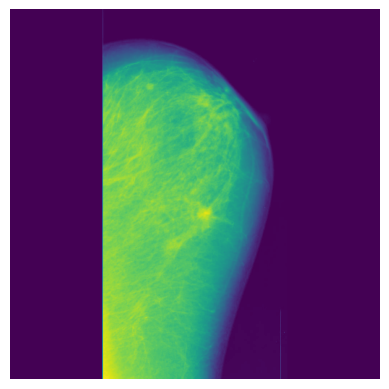

Classification Label: [0. 1. 0.]
Localization Label: [0.49541286 0.51926607 0.08073395]


In [41]:
# Visualize the first few samples from the dataset
visualize_dataset(train_dataset)

(512, 512, 1)


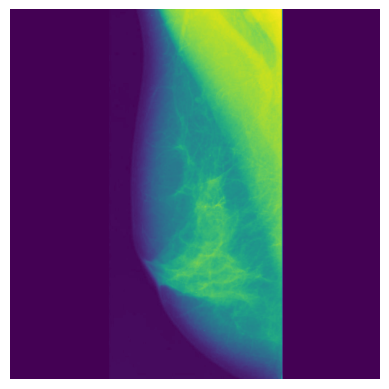

Classification Label: [0. 1. 0.]
Localization Label: [0.50642204 0.46055046 0.04770642]


In [42]:
# Visualize the first few samples from the dataset
visualize_dataset(test_dataset)

In [43]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, Accuracy

import math
import tensorflow.keras.backend as K


def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Input layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))



## Feature Extractor
x = tf.keras.layers.Conv2D(16, activation="relu", kernel_size=3,
                             input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)






## Dense Layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
feature = tf.keras.layers.Dense(64, activation = 'relu')(x)

## Classification head
x = tf.keras.layers.Dense(128, activation = 'relu')(feature)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
classification_output = tf.keras.layers.Dense(3, activation="softmax", name="classification")(x)

## Localization Head
x = tf.keras.layers.Dense(128, activation = 'relu')(feature)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
localization_output = tf.keras.layers.Dense(units=3, activation = 'relu', name="localization")(x)


model = tf.keras.Model(inputs=inputs, outputs=[classification_output, localization_output])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'classification': "categorical_crossentropy",
                    'localization': "mse"},
              loss_weights={'classification': 1.0,
                            'localization': 1.0},
              metrics={'classification': ['accuracy', AUC()],
                       'localization': ['mse', r_squared]})
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 510, 510,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 510, 510,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 255, 255,  │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 255, 255,  │          0 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 253, 253,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 253, 253,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 126, 126,  │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 126, 126,  │          0 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 124,  │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 124,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 62, 62,    │          0 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 60, 60,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 30, 30,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     36,928 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_4[0][0]  

 Total params: 1,347,750 (5.14 MB)

 Trainable params: 1,346,886 (5.14 MB)

 Non-trainable params: 864 (3.38 KB)

In [44]:
num_epochs = 300

# Fit the model with the training data
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=test_dataset,
                    shuffle = True)

Epoch 1/300


2024-05-11 20:45:34.969180: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5825: 0.647189, expected 0.477991
2024-05-11 20:45:34.969244: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6215: 0.410816, expected 0.241618
2024-05-11 20:45:34.969256: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6725: 0.606545, expected 0.437347
2024-05-11 20:45:34.969270: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7912: 0.595247, expected 0.426048
2024-05-11 20:45:34.969315: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15854: 0.647189, expected 0.477991
2024-05-11 20:45:34.969324: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16246: 0.410816, expected 0.241618
2024-05-11 20:45:34.969336: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16756: 0.606545, expected 0.437347
2024-05-11 20:45:

 3/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - classification_accuracy: 0.3333 - classification_auc: 0.4372 - localization_mse: 0.0825 - localization_r_squared: -0.5214 - loss: 1.2005

I0000 00:00:1715460350.739397     128 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715460350.770489     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - classification_accuracy: 0.3510 - classification_auc: 0.5156 - localization_mse: 0.0574 - localization_r_squared: -0.0152 - loss: 1.1742

2024-05-11 20:45:59.943930: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.71291, expected 3.14355
2024-05-11 20:45:59.943991: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.80486, expected 3.2355
2024-05-11 20:45:59.944001: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.7522, expected 3.18284
2024-05-11 20:45:59.944008: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.75217, expected 3.18281
2024-05-11 20:45:59.944016: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.40039, expected 3.83103
2024-05-11 20:45:59.944024: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.32475, expected 3.75539
2024-05-11 20:45:59.944032: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 3.31867, expected 2.74931
2024-05-11 20:45:59.944041: E external/local_xla/xla/serv

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - classification_accuracy: 0.3510 - classification_auc: 0.5156 - localization_mse: 0.0573 - localization_r_squared: -0.0128 - loss: 1.1740

W0000 00:00:1715460374.970820     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-05-11 20:46:15.964013: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.45549, expected 2.6926
2024-05-11 20:46:15.964071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.19187, expected 2.42899
2024-05-11 20:46:15.964081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.04121, expected 2.27832
2024-05-11 20:46:15.964089: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.3637, expected 2.60082
2024-05-11 20:46:15.964098: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.65672, expected 2.89383
2024-05-11 20:46:15.964106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.34674, expected 3.58385
2024-05-11 20:46:15.964114: E external/local_xla/xla/service/gpu/bu

55/55 ━━━━━━━━━━━━━━━━━━━━ 58s 509ms/step - classification_accuracy: 0.3510 - classification_auc: 0.5156 - localization_mse: 0.0572 - localization_r_squared: -0.0105 - loss: 1.1738 - val_classification_accuracy: 0.3333 - val_classification_auc: 0.4917 - val_localization_mse: 0.0428 - val_localization_r_squared: 0.2188 - val_loss: 1.1507
Epoch 2/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - classification_accuracy: 0.3567 - classification_auc: 0.5128 - localization_mse: 0.0452 - localization_r_squared: 0.2009 - loss: 1.1452 - val_classification_accuracy: 0.3333 - val_classification_auc: 0.5094 - val_localization_mse: 0.0413 - val_localization_r_squared: 0.2470 - val_loss: 1.1413
Epoch 3/300
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - classification_accuracy: 0.3468 - classification_auc: 0.5299 - localization_mse: 0.0448 - localization_r_squared: 0.1931 - loss: 1.1496 - val_classification_accuracy: 0.3361 - val_classification_auc: 0.5226 - val_localization_mse: 0.0405 - val_localization_r_

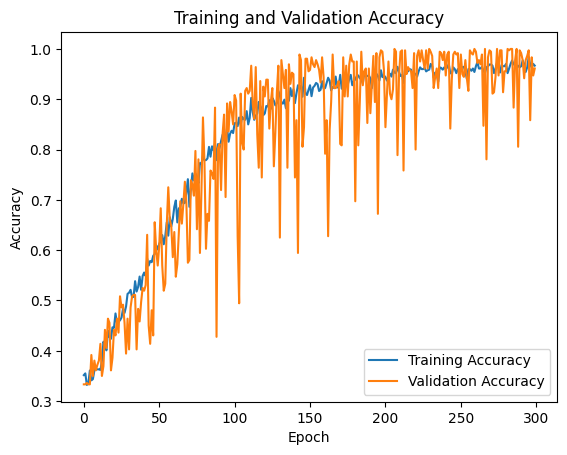

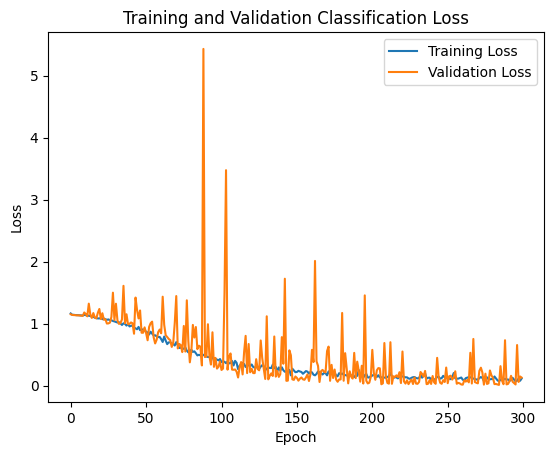

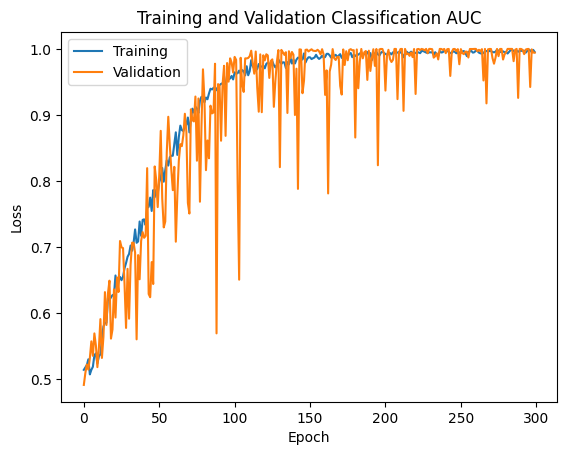

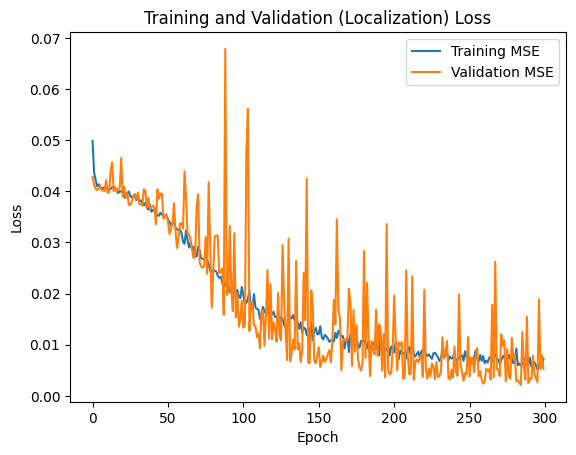

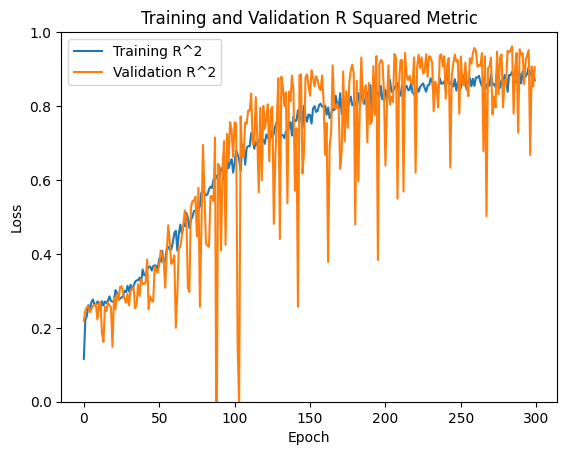

In [45]:

# Plot training and validation accuracy
plt.plot(history.history['classification_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_classification_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation AUC
plt.plot(history.history['classification_auc'], label='Training ')
plt.plot(history.history['val_classification_auc'], label='Validation')
plt.title('Training and Validation Classification AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['localization_mse'], label='Training MSE')
plt.plot(history.history['val_localization_mse'], label='Validation MSE')
plt.title('Training and Validation (Localization) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation r^2
plt.plot(history.history['localization_r_squared'], label='Training R^2')
plt.plot(history.history['val_localization_r_squared'], label='Validation R^2')
plt.title('Training and Validation R Squared Metric')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


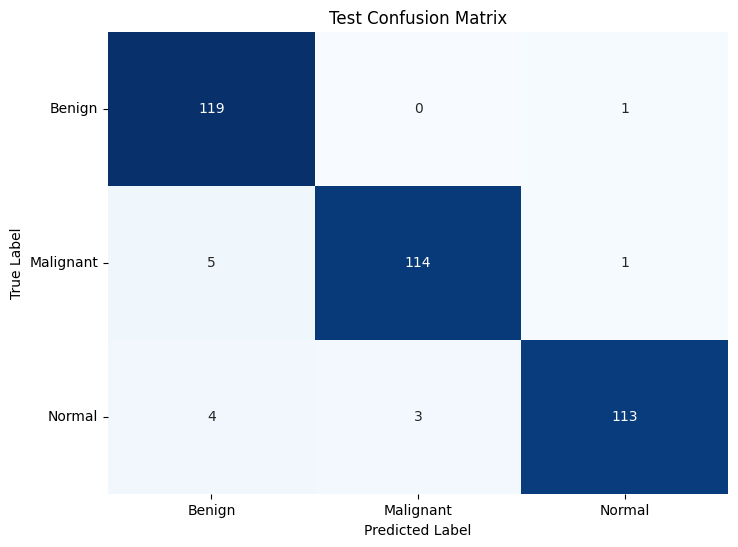

Accuracy: 0.9611111111111111
F1 Score: 0.9611349544900365
Precision: 0.962218390003716
Recall: 0.9611111111111111


In [49]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Extracting classification predictions from the model output
classification_predictions = np.argmax(predictions[0], axis=1)

# Extracting true labels from the test dataset
true_labels = dftest['severity_encoded'].values

# Map numeric labels to class names
class_names = {
    0: "Benign",
    1: "Malignant",
    2: "Normal"
}

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, classification_predictions)

accuracy = accuracy_score(true_labels, classification_predictions)
f1 = f1_score(true_labels, classification_predictions, average='weighted')

# Calculate precision
precision = precision_score(true_labels, classification_predictions, average='weighted')

# Calculate recall
recall = recall_score(true_labels, classification_predictions, average='weighted')


# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')

# Set ticks
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(np.arange(len(class_names)) + 0.5, tick_labels)
plt.yticks(np.arange(len(class_names)) + 0.5, tick_labels, rotation=0)

plt.show()


# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)



55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


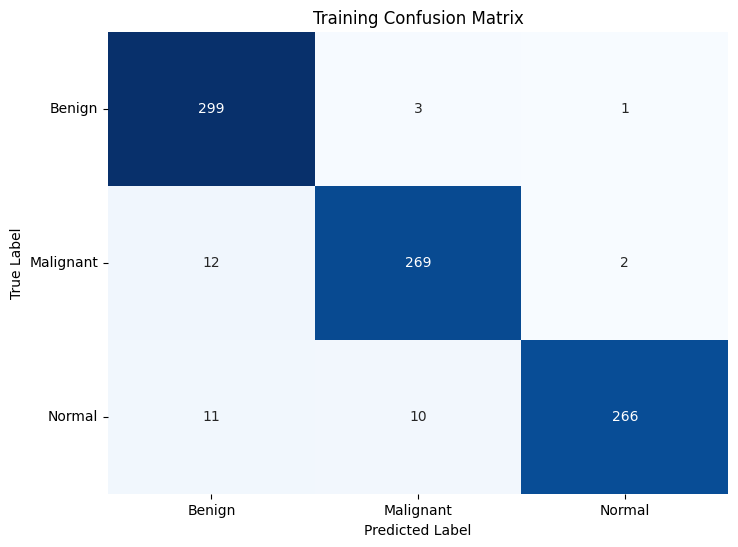

Accuracy: 0.9553264604810997
F1 Score: 0.9553241889874652
Precision: 0.9565982818693458
Recall: 0.9553264604810997


In [50]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
train_dataset_1 = training_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Make predictions on the test dataset
predictions = model.predict(train_dataset_1)

# Extracting classification predictions from the model output
classification_predictions = np.argmax(predictions[0], axis=1)

# Extracting true labels from the test dataset
true_labels = dftrain['severity_encoded'].values

# Map numeric labels to class names
class_names = {
    0: "Benign",
    1: "Malignant",
    2: "Normal"
}

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, classification_predictions)

accuracy = accuracy_score(true_labels, classification_predictions)
f1 = f1_score(true_labels, classification_predictions, average='weighted')

# Calculate precision
precision = precision_score(true_labels, classification_predictions, average='weighted')

# Calculate recall
recall = recall_score(true_labels, classification_predictions, average='weighted')


# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Confusion Matrix')

# Set ticks
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(np.arange(len(class_names)) + 0.5, tick_labels)
plt.yticks(np.arange(len(class_names)) + 0.5, tick_labels, rotation=0)

plt.show()


# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)



23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


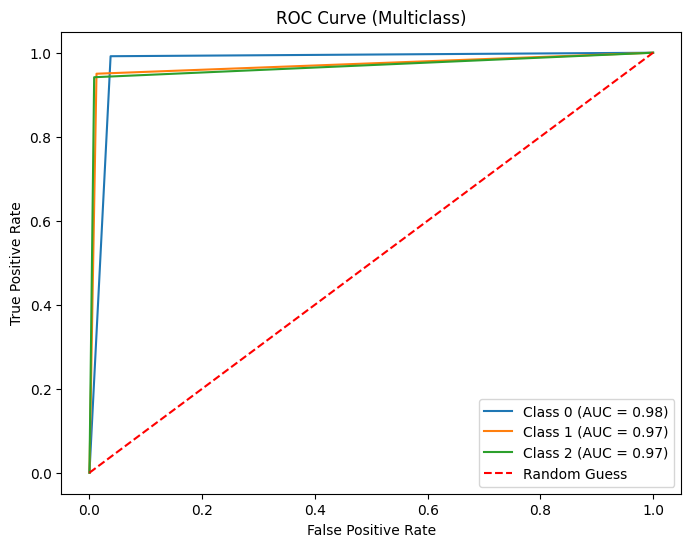

In [52]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer


predictions = model.predict(test_dataset)
classification_predictions = np.argmax(predictions[0], axis=1)
true_labels = dftest['severity_encoded'].values

label_binarizer = LabelBinarizer()
y_true_binary = label_binarizer.fit_transform(true_labels)
y_pred_binary = label_binarizer.fit_transform(classification_predictions)
n_classes = y_true_binary.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = roc_auc_score(y_true_binary[:, i], y_pred_binary[:, i])

# Plot ROC AUC scores for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass)')
plt.legend()
plt.show()

